In [2]:
import torch
import torch.nn as nn
from network import GCNet
from train import train_model, plot_results
from data2 import get_sdf_data_loader

In [8]:
n_objects, batch_size, n_epoch = 100, 1, 200
in_channels, out_channels = 3, 1
hidden_channels = [16, 64, 128, 64, 16]
loss_func = nn.L1Loss()
edge_weight = True
step_size, gamma = 60, 0.5
lr_0 = 0.001

preparing sdf data loader
training begins
epoch=10, loss=1.28307e-01, lr=1.00000e-03
epoch=20, loss=1.21512e-01, lr=1.00000e-03
epoch=30, loss=1.19495e-01, lr=1.00000e-03
epoch=40, loss=1.17294e-01, lr=1.00000e-03
epoch=50, loss=1.17165e-01, lr=1.00000e-03
epoch=60, loss=1.16199e-01, lr=5.00000e-04
epoch=70, loss=1.14329e-01, lr=5.00000e-04
epoch=80, loss=1.13770e-01, lr=5.00000e-04
epoch=90, loss=1.13469e-01, lr=5.00000e-04
epoch=100, loss=1.13177e-01, lr=5.00000e-04
epoch=110, loss=1.13277e-01, lr=5.00000e-04
epoch=120, loss=1.13020e-01, lr=2.50000e-04
epoch=130, loss=1.11936e-01, lr=2.50000e-04
epoch=140, loss=1.11740e-01, lr=2.50000e-04
epoch=150, loss=1.11642e-01, lr=2.50000e-04
epoch=160, loss=1.11649e-01, lr=2.50000e-04
epoch=170, loss=1.11681e-01, lr=2.50000e-04
epoch=180, loss=1.11566e-01, lr=1.25000e-04
epoch=190, loss=1.11021e-01, lr=1.25000e-04


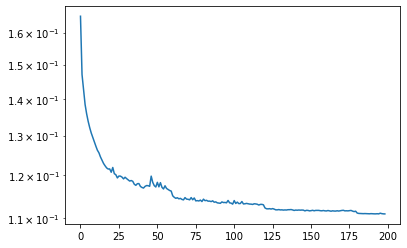

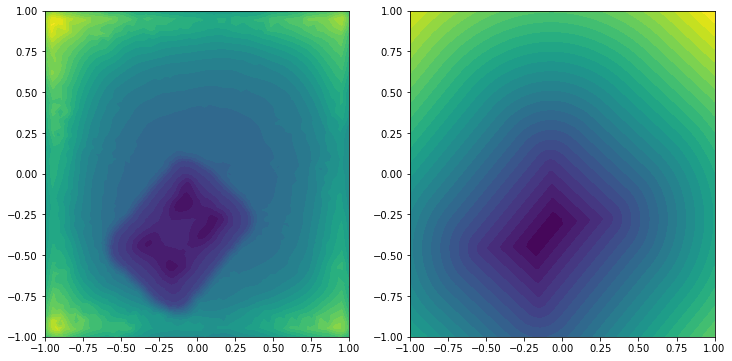

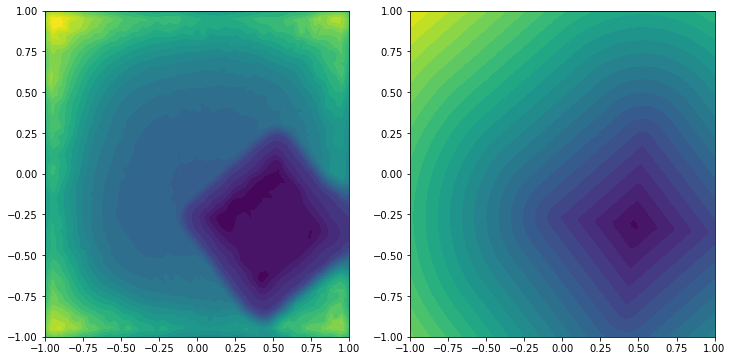

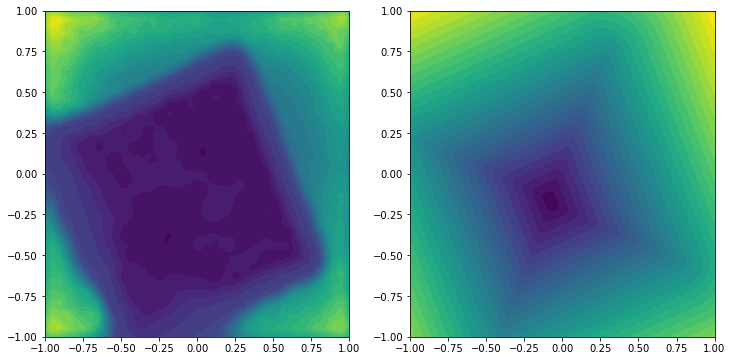

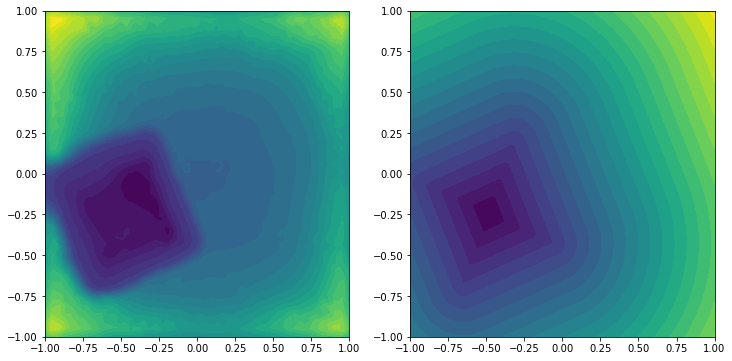

In [4]:
data_folder = "data2/dataset_1/graph1/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

preparing sdf data loader
training begins
epoch=10, loss=1.09523e-01, lr=1.00000e-03
epoch=20, loss=1.03707e-01, lr=1.00000e-03
epoch=30, loss=1.00469e-01, lr=1.00000e-03
epoch=40, loss=9.81076e-02, lr=1.00000e-03
epoch=50, loss=9.67314e-02, lr=1.00000e-03
epoch=60, loss=9.54965e-02, lr=5.00000e-04
epoch=70, loss=9.31870e-02, lr=5.00000e-04
epoch=80, loss=9.31286e-02, lr=5.00000e-04
epoch=90, loss=9.35023e-02, lr=5.00000e-04
epoch=100, loss=9.22785e-02, lr=5.00000e-04
epoch=110, loss=9.23460e-02, lr=5.00000e-04
epoch=120, loss=9.28085e-02, lr=2.50000e-04
epoch=130, loss=9.04068e-02, lr=2.50000e-04
epoch=140, loss=9.00954e-02, lr=2.50000e-04
epoch=150, loss=8.99366e-02, lr=2.50000e-04
epoch=160, loss=8.97303e-02, lr=2.50000e-04
epoch=170, loss=8.96309e-02, lr=2.50000e-04
epoch=180, loss=8.94920e-02, lr=1.25000e-04
epoch=190, loss=8.88632e-02, lr=1.25000e-04


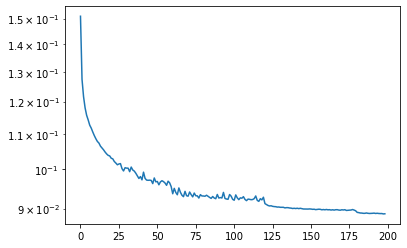

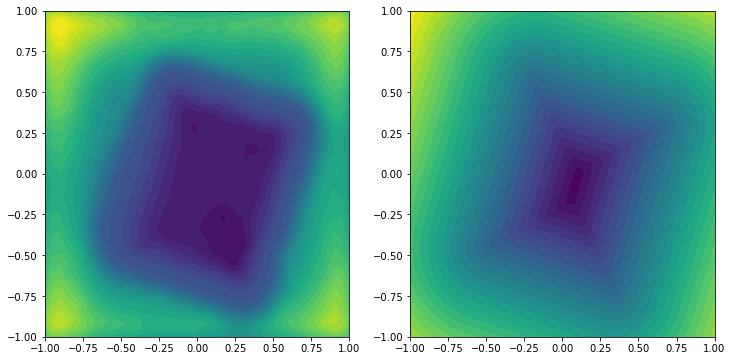

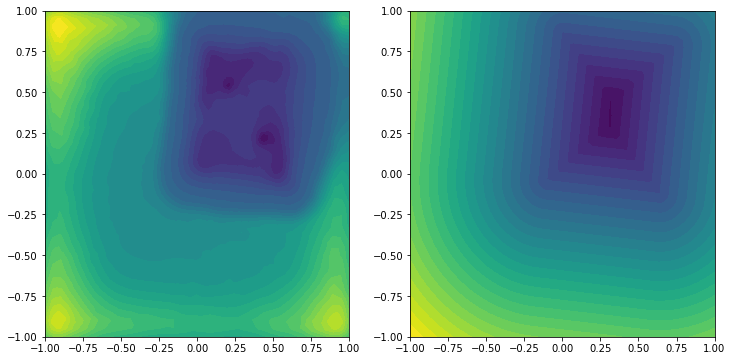

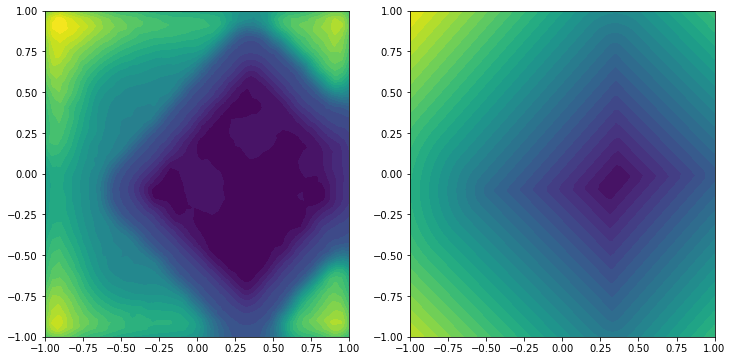

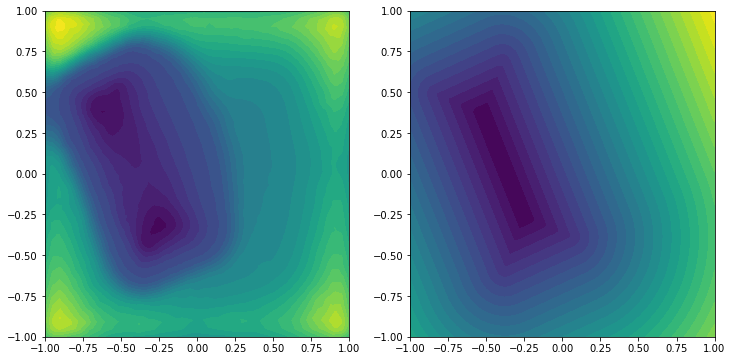

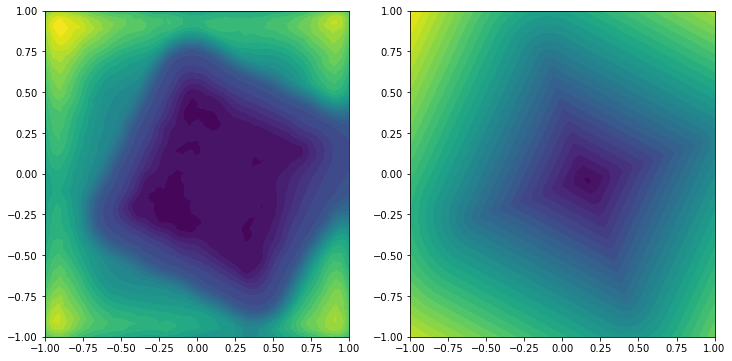

In [9]:
data_folder = "data2/dataset_1/graph2/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

preparing sdf data loader
training begins
epoch=10, loss=1.09009e-01, lr=1.00000e-03
epoch=20, loss=1.03191e-01, lr=1.00000e-03
epoch=30, loss=1.02770e-01, lr=1.00000e-03
epoch=40, loss=9.92197e-02, lr=1.00000e-03
epoch=50, loss=9.81767e-02, lr=1.00000e-03
epoch=60, loss=9.74892e-02, lr=5.00000e-04
epoch=70, loss=9.48821e-02, lr=5.00000e-04
epoch=80, loss=9.50467e-02, lr=5.00000e-04
epoch=90, loss=9.46864e-02, lr=5.00000e-04
epoch=100, loss=9.44057e-02, lr=5.00000e-04
epoch=110, loss=9.41933e-02, lr=5.00000e-04
epoch=120, loss=9.43513e-02, lr=2.50000e-04
epoch=130, loss=9.24915e-02, lr=2.50000e-04
epoch=140, loss=9.22935e-02, lr=2.50000e-04
epoch=150, loss=9.21744e-02, lr=2.50000e-04
epoch=160, loss=9.20142e-02, lr=2.50000e-04
epoch=170, loss=9.18460e-02, lr=2.50000e-04
epoch=180, loss=9.17875e-02, lr=1.25000e-04
epoch=190, loss=9.11105e-02, lr=1.25000e-04


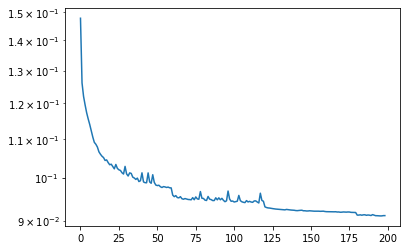

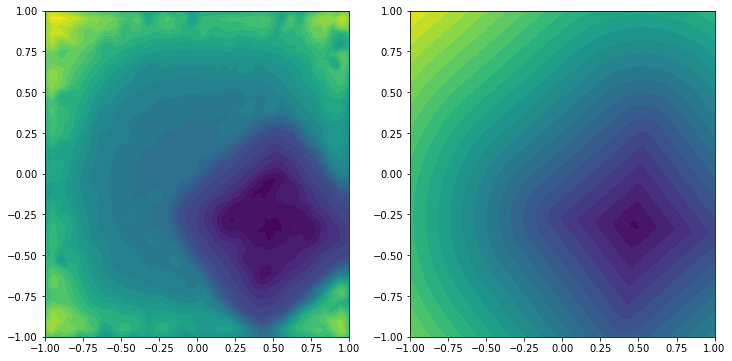

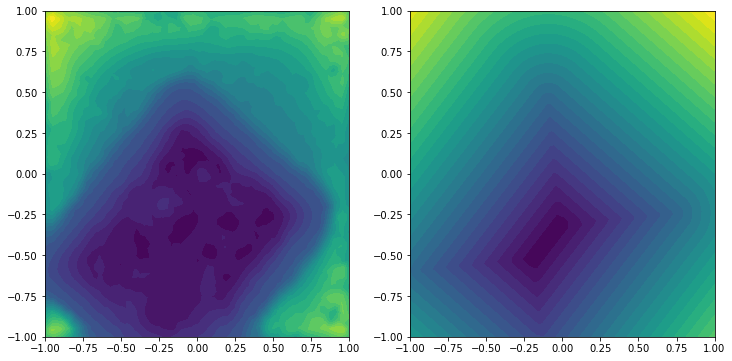

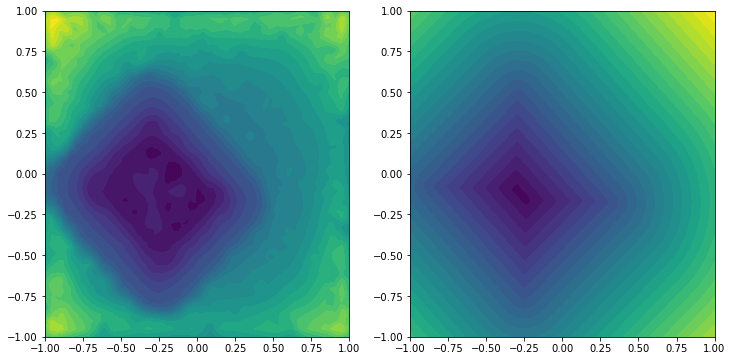

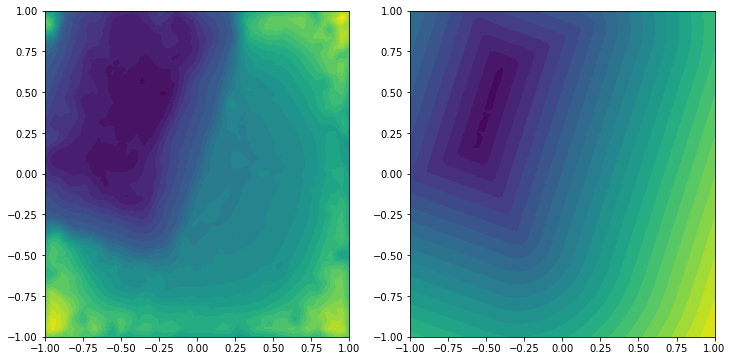

In [11]:
data_folder = "data2/dataset_1/graph3/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

preparing sdf data loader
training begins
epoch=10, loss=1.03917e-01, lr=1.00000e-03
epoch=20, loss=9.61148e-02, lr=1.00000e-03
epoch=30, loss=9.29715e-02, lr=1.00000e-03
epoch=40, loss=9.16305e-02, lr=1.00000e-03
epoch=50, loss=9.04113e-02, lr=1.00000e-03
epoch=60, loss=8.96262e-02, lr=5.00000e-04
epoch=70, loss=8.63567e-02, lr=5.00000e-04
epoch=80, loss=8.57308e-02, lr=5.00000e-04
epoch=90, loss=8.52770e-02, lr=5.00000e-04
epoch=100, loss=8.48187e-02, lr=5.00000e-04
epoch=110, loss=8.44147e-02, lr=5.00000e-04
epoch=120, loss=8.40797e-02, lr=2.50000e-04
epoch=130, loss=8.25343e-02, lr=2.50000e-04
epoch=140, loss=8.21923e-02, lr=2.50000e-04
epoch=150, loss=8.19406e-02, lr=2.50000e-04
epoch=160, loss=8.17220e-02, lr=2.50000e-04
epoch=170, loss=8.15344e-02, lr=2.50000e-04
epoch=180, loss=8.13527e-02, lr=1.25000e-04
epoch=190, loss=8.00161e-02, lr=1.25000e-04


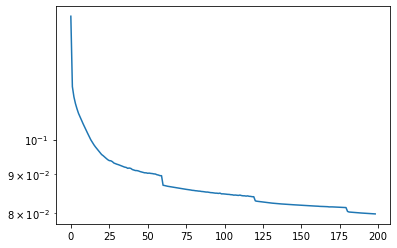

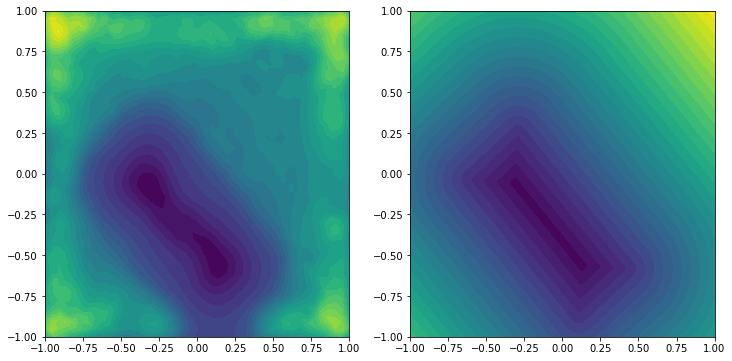

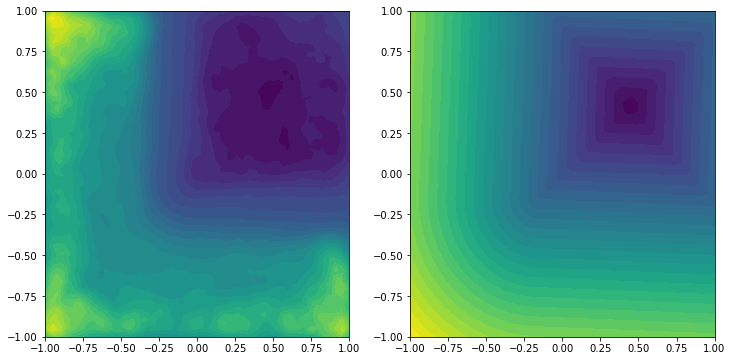

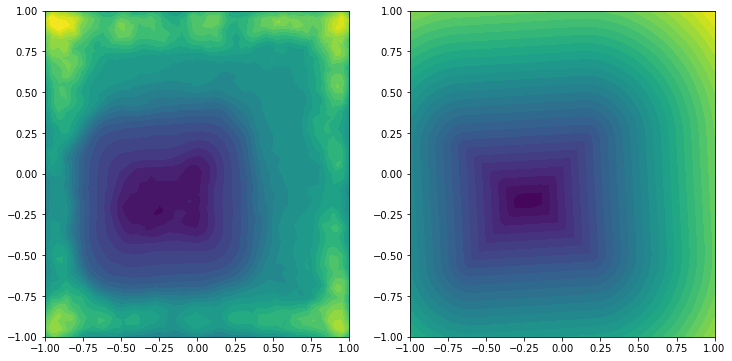

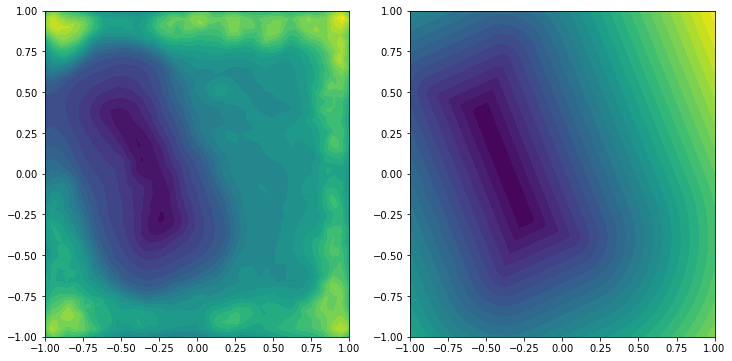

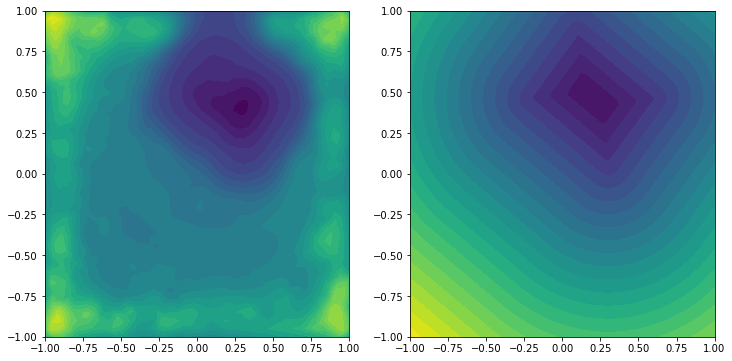

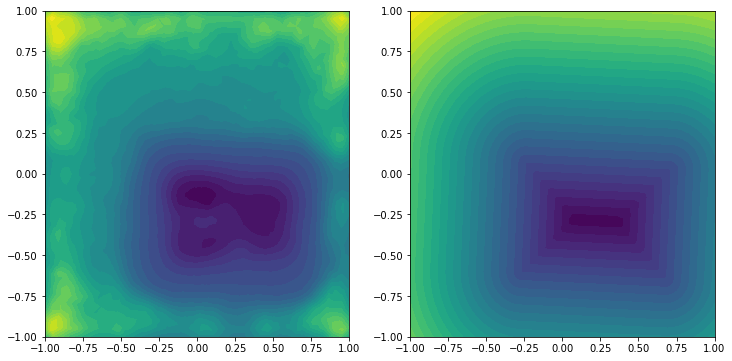

In [13]:
data_folder = "data2/dataset_1/graph4/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

preparing sdf data loader
training begins
epoch=10, loss=8.91303e-02, lr=1.00000e-03
epoch=20, loss=8.52030e-02, lr=1.00000e-03
epoch=30, loss=8.19890e-02, lr=1.00000e-03
epoch=40, loss=8.01451e-02, lr=1.00000e-03
epoch=50, loss=7.91077e-02, lr=1.00000e-03
epoch=60, loss=7.76254e-02, lr=1.00000e-03
epoch=70, loss=7.62016e-02, lr=1.00000e-03
epoch=80, loss=7.55267e-02, lr=1.00000e-03
epoch=90, loss=7.44206e-02, lr=1.00000e-03
epoch=100, loss=7.33297e-02, lr=1.00000e-03
epoch=110, loss=7.25988e-02, lr=1.00000e-03
epoch=120, loss=7.17949e-02, lr=1.00000e-03
epoch=130, loss=7.13322e-02, lr=1.00000e-03
epoch=140, loss=7.08223e-02, lr=1.00000e-03
epoch=150, loss=7.06454e-02, lr=5.00000e-04
epoch=160, loss=6.73631e-02, lr=5.00000e-04
epoch=170, loss=6.68624e-02, lr=5.00000e-04
epoch=180, loss=6.64201e-02, lr=5.00000e-04
epoch=190, loss=6.60696e-02, lr=5.00000e-04
epoch=200, loss=6.56838e-02, lr=5.00000e-04
epoch=210, loss=6.53603e-02, lr=5.00000e-04
epoch=220, loss=6.50170e-02, lr=5.00000e-04

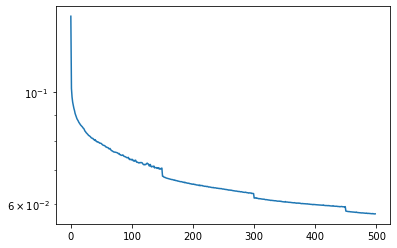

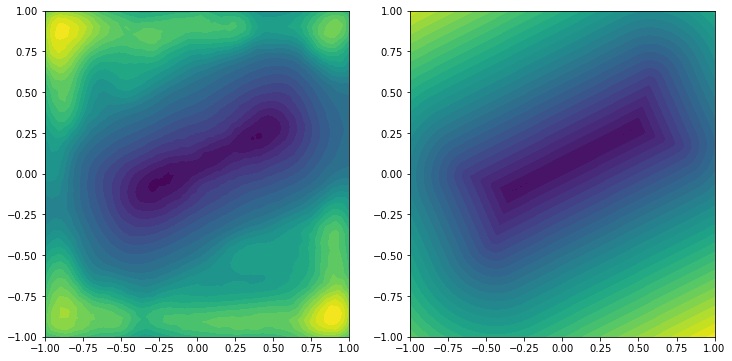

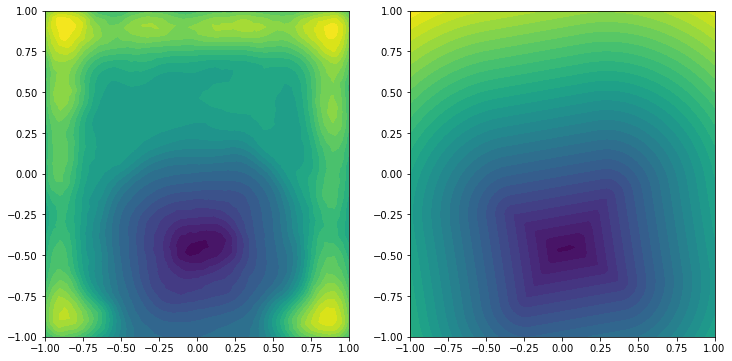

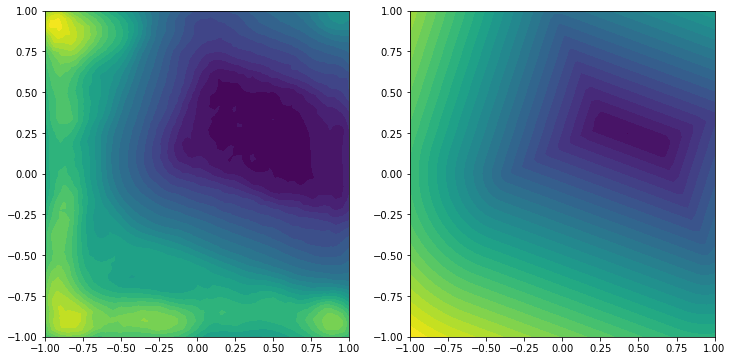

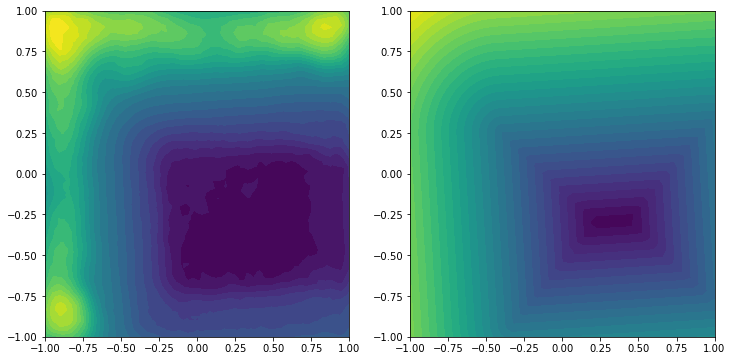

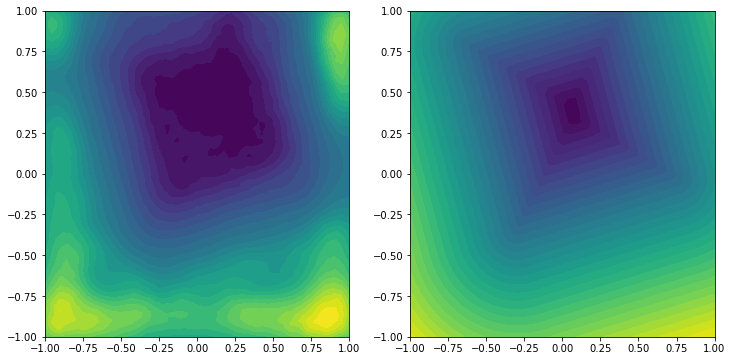

In [15]:
step_size, gamma, n_epoch = 150, 0.5, 500
data_folder = "data2/dataset_1/graph5/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

preparing sdf data loader
training begins
epoch=10, loss=1.00537e-01, lr=1.00000e-03
epoch=20, loss=9.31432e-02, lr=1.00000e-03
epoch=30, loss=9.07557e-02, lr=1.00000e-03
epoch=40, loss=8.95943e-02, lr=1.00000e-03
epoch=50, loss=8.81312e-02, lr=1.00000e-03
epoch=60, loss=8.65025e-02, lr=1.00000e-03
epoch=70, loss=8.57407e-02, lr=1.00000e-03
epoch=80, loss=8.56852e-02, lr=1.00000e-03
epoch=90, loss=8.43122e-02, lr=1.00000e-03
epoch=100, loss=8.33459e-02, lr=1.00000e-03
epoch=110, loss=8.32676e-02, lr=1.00000e-03
epoch=120, loss=8.26857e-02, lr=1.00000e-03
epoch=130, loss=8.30763e-02, lr=1.00000e-03
epoch=140, loss=8.14978e-02, lr=1.00000e-03
epoch=150, loss=8.24707e-02, lr=5.00000e-04
epoch=160, loss=7.82738e-02, lr=5.00000e-04
epoch=170, loss=7.81457e-02, lr=5.00000e-04
epoch=180, loss=7.73905e-02, lr=5.00000e-04
epoch=190, loss=7.70255e-02, lr=5.00000e-04
epoch=200, loss=7.69013e-02, lr=5.00000e-04
epoch=210, loss=7.65258e-02, lr=5.00000e-04
epoch=220, loss=7.61557e-02, lr=5.00000e-04

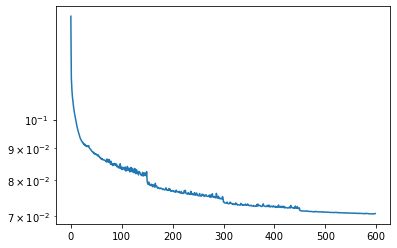

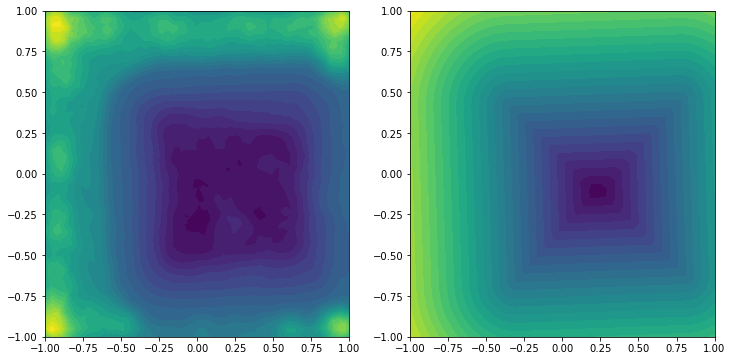

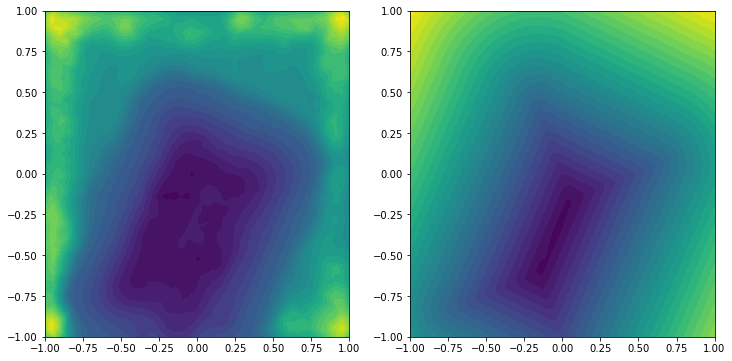

In [17]:
step_size, gamma, n_epoch = 150, 0.5, 600
data_folder = "data2/dataset_1/graph6/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)